# Import Function

In [1]:
import sys
sys.path.append('C://Users/Administrator/Desktop/packages/lzp_utils')

In [2]:
pwd

'C:\\Users\\Administrator\\Desktop\\packages\\lzp_utils'

In [3]:
from import_packages import *
from tools import *
from sample_exploration import get_od_label
from data_aggregation import *
from data_cleaning import DATA_FILTER
from sample_exploration import get_pos_rate,desc_stat,feats_coverage_stat,sample_coverage_stat
from sample_splitter import SAMPLE_SPLITTER
from feature_transformation import UD_TRANSFORMER
from feature_trimming import UD_TRIMMER
from feature_scaling import UD_SCALER
from feature_encoding import UD_FEATURE_ENCODER
from feature_imputation import UD_IMPUTER
from feature_selection import FEATURE_FILTER
from feature_evaluation import get_vif_cor, plot_hist_all
from model_training import BAYESIAN_OPTIMIZATION, cv_check, xgbt, model_toolkit, model_selection
from model_evaluation import plot_all_figures
from recoding_statement import GENERATE_OUTPUT_FILES

D:\Softwares\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
D:\Softwares\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Softwares\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Import Data

In [4]:
path = "E://zipeng.lin/20190122_cscore_v1/data/"


## Import Data

In [5]:
df = df_ori = pd.read_csv("E://zipeng.lin/20190122_cscore_v1/data/" + 'maimaiche_data.csv', encoding='utf-8', sep='	')
del df['Unnamed: 0']
df = df[df.label != -1]


In [6]:
# ### Multinominal Recoding: yys_phoneLocation ###
# df.loc[:,'r_yys_phonelocation_x1'] = 0
# df.loc[[str(x) in ['江苏', '江西', '北京', '新疆', '青海', '山西'] for x in df['yys_phoneLocation']],'r_yys_phonelocation_x1'] = 1
# df.loc[:,'r_yys_phonelocation_x8'] = 0
# df.loc[[str(x) in ['海南', '西藏', '宁夏', '浙江', '云南'] for x in df['yys_phoneLocation']],'r_yys_phonelocation_x8'] = 1
# df.loc[:,'r_woe_yys_phonelocation'] = 0
# df.loc[[str(x) in ['江苏', '江西', '北京', '新疆', '青海', '山西'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = -0.4689567747639032
# df.loc[[str(x) in ['天津', '陕西', '湖南'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = -0.3105671449368131
# df.loc[[str(x) in ['贵州', '河南'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = -0.2686248256954831
# df.loc[[str(x) in ['四川', '湖北', '广东'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = -0.22964553209031047
# df.loc[[str(x) in ['广西', '安徽', '河北'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = -0.11521516109294408
# df.loc[[str(x) in ['甘肃', '黑龙江', '上海', '山东', '福建'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = 0.005071004781557793
# df.loc[[str(x) in ['重庆', 'nan', '内蒙古', '辽宁', '吉林'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = 0.20465886310487688
# df.loc[[str(x) in ['海南', '西藏', '宁夏', '浙江', '云南'] for x in df['yys_phoneLocation']],'r_woe_yys_phonelocation'] = 0.4923661311373545

# ### Multinominal Recoding: yys_friendMap ###
# df.loc[:,'r_yys_friendmap_x1'] = 0
# df.loc[[str(x) in ['江西', '新疆', '山西', '上海'] for x in df['yys_friendMap']],'r_yys_friendmap_x1'] = 1
# df.loc[:,'r_yys_friendmap_x10'] = 0
# df.loc[[str(x) in ['海南', '西藏', '宁夏', '浙江', '云南'] for x in df['yys_friendMap']],'r_yys_friendmap_x10'] = 1
# df.loc[:,'r_woe_yys_friendmap'] = 0
# df.loc[[str(x) in ['江西', '新疆', '山西', '上海'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.5348720175551599
# df.loc[[str(x) in ['贵州', '青海', '河南'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.36057260913993505
# df.loc[[str(x) in ['北京', '陕西', '全国'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.3401349118084096
# df.loc[[str(x) in ['湖北', '江苏', '湖南'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.2453883571796148
# df.loc[[str(x) in ['广东'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.21223027090842347
# df.loc[[str(x) in ['广西', '河北', '黑龙江'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = -0.09846967415928247
# df.loc[[str(x) in ['福建', '安徽', '山东', '四川'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = 0.005071004781557793
# df.loc[[str(x) in ['甘肃', '辽宁'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = 0.07849847333637512
# df.loc[[str(x) in ['重庆', 'nan', '内蒙古', '吉林', '天津'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = 0.21128688177494853
# df.loc[[str(x) in ['海南', '西藏', '宁夏', '浙江', '云南'] for x in df['yys_friendMap']],'r_woe_yys_friendmap'] = 0.5364629061290256

# ### Multinominal Recoding: baidu_risk_blacklevel ###
# df.loc[:,'r_woe_baidu_risk_blacklevel'] = 0
# df.loc[[str(x) in ['A', 'B', 'nan'] for x in df['baidu_risk_blacklevel']],'r_woe_baidu_risk_blacklevel'] = -0.03071591346561235
# df.loc[[str(x) in ['D', 'C'] for x in df['baidu_risk_blacklevel']],'r_woe_baidu_risk_blacklevel'] = 0.3625268937033615


In [7]:
# col=list(set(df.select_dtypes(exclude = [object]).columns.tolist()) \
#              - set(['label','audit_info_id','delay_over_30','max_delay_date','create_till_now','loan_till_now','max_cur_term']))


In [8]:
# x_train, real_train_label, x_val, real_val_label, x_test, real_test_label = SAMPLE_SPLITTER(df,'label','loan_date',['docid','create_date'],oot_size=0.05)


In [9]:
# dtrain = xgb.DMatrix(x_train[col], label=real_train_label)
# dval = xgb.DMatrix(x_val[col], label=real_val_label)
# dtest = xgb.DMatrix(x_test[col], label=real_test_label)


In [10]:
# params = {}
# params['objective'] = 'binary:logistic'
# params['eval_metric'] = 'auc'
# params['min_child_weight'] = 5
# params['eta'] = 0.1
# params['max_depth'] = 1
# params['subsample'] = 0.9
# params['colsample_bytree'] = 0.9
# params['silent'] = 0
# params['seed'] = 2019
# params['lambda'] = 30
# params['max_delta_step'] = 0
# # params['scale_pos_weight'] = 10

# watchlist = [(dtrain, 'train'), (dval, 'eval')]
# model1 = xgb.train(params, dtrain, num_boost_round=10000, evals=watchlist,
#                   verbose_eval=True, early_stopping_rounds=50)


In [11]:
# pred_train_value = model1.predict(dtrain)
# pred_val_value = model1.predict(dval)
# pred_test_value = model1.predict(dtest)


In [12]:
# tr,va,te = plot_all_figures(pred_train_value, real_train_label, pred_val_value, real_val_label, pred_test_value=pred_test_value,
#                   real_test_label=real_test_label, pos_label=1)


In [13]:
# df = df_ori = pd.read_csv(path + 'maimaiche_data.csv',encoding = 'utf-8', sep = '	')
# del df['Unnamed: 0']
# df = df[df.label != -1]


# Global Definition

In [14]:
# label used to train models
label = 'label'

#--------------------------------------------------------------------------------------------------#
# column recording datetime
dt_col = 'loan_date'

#--------------------------------------------------------------------------------------------------#
# column recording unique id
uid = 'docid'

#--------------------------------------------------------------------------------------------------#
# column recording overdue days
od_col = 'max_delay_date'

#--------------------------------------------------------------------------------------------------#
# columns excluded from feature engineering and model training
exclude_list = [] + [dt_col] + [uid]

#--------------------------------------------------------------------------------------------------#
# columns of boolean targets used to explore data
# target = ['d0', 'd1', 'd3', 'd7']
target = ['label']

#--------------------------------------------------------------------------------------------------#
# produce targets if none is given
if len(set(target) - set(df.columns)) != 0:
    df = get_od_label(df, OD_TARGET=OD_TARGET, col=od_col, drop=False, event=1)
    
#--------------------------------------------------------------------------------------------------#
# output files' name
recoding_file = 'Feature_Recoding_Statement_for_Sample_Model.txt'
woe_recoding_stat_file = 'Feature_Woe_Recoding_Statistics_for_Sample_Model.xlsx'
feature_stat_file = 'Feature_Statistical_Summary_for_Sample_Model.xlsx'
lr_model_equation_file = 'Equation_for_Sample_LR_Model.txt'
lr_model_summary_file = 'Summary_for_Sample_LR_Model.xlsx'


In [15]:
# use lR model or not
model_linear = True

#--------------------------------------------------------------------------------------------------#
# whether transform, trim, scale, woe-encode and impute features
use_transformr = False
use_trimmr = False
use_scalr = False
use_woe_encoder = True
use_imputr = True
#--------------------------------------------------------------------------------------------------#
if model_linear:
    use_transformr = True
    use_trimmr = True
    use_scalr = True
    use_woe_encoder = True
    use_imputr = True

#--------------------------------------------------------------------------------------------------#
# whether use iv and model's feature importance to filter features (XGBoost, RandomForest and LR models are supported)
use_iv_filtr = True
use_xgbfi_filtr = True
use_rffi_filtr = True
use_lr_filtr = True
#--------------------------------------------------------------------------------------------------#
# number of remaining features after each step
xgb_feat_cnt = 25
rf_feat_cnt = 22
lr_feat_cnt = 18


# AUTO ML

## DATA CLEANING

In [16]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################    1. DATA CLEANING    ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Filter columns with number of unique values below defined threshold. Filter columns with missing rates
# above defined threshold. Filter columns with a value of high frequency above defined threshold
#--------------------------------------------------------------------------------------------------#
# : params nunique_thr: threshold of unique values number
# : params missing_rate_thr: missing rate threshold
# : params HF_value_thr: threshold of high-frequency value's occurrence propability
# : params drop_cols: list of columns should be removed manually
filtr = DATA_FILTER(nunique_thr=2, missing_rate_thr=0.99, HF_value_thr=0.98, silent=False,
                    drop_cols=['name', 'mobile', 'create_date', 'audit_info_id', 'tj_yys_audit_info_id',
                               'yys_v2Flag_name', 'max_cur_term', 'max_delay_date', 'delay_over_30'])
#--------------------------------------------------------------------------------------------------#
df = filtr.ud_fit_transform(df)


Statistics of columns to be dropped 

                          unique_value_cnt missing_rate  HF_value_pct
yys_specialCate13TalkNum                 0      100.00%           NaN
yys_specialCate16TalkNum                 0      100.00%           NaN
yys_specialCate15TalkNum                 0      100.00%           NaN
yys_AveMonthlyConsume                    0      100.00%           NaN
rn                                       1        0.00%      1.000000
gzt_is_reject                            1        0.05%      0.999471
yys_friendMap_2                          0      100.00%           NaN
yys_specialCate13TalkNum                 0      100.00%           NaN
yys_specialCate16TalkNum                 0      100.00%           NaN
yys_specialCate15TalkNum                 0      100.00%           NaN
yys_AveMonthlyConsume                    0      100.00%           NaN
yys_friendMap_2                          0      100.00%           NaN
rn                                       1        0.

## DATA AGGREGATION

In [17]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################  2. DATA AGGREGATION   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Apply RFM rule to do feature engineering where samples are aggregated by defined aggregate keys 
# and limitted by defined time spans in combinations


## SAMPLE EXPLORATION

In [18]:
####################################################################################################
####################################################################################################
######################################                        ######################################
###################################### 3. SAMPLE EXPLORATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# 1.Calculate positive rate (dependent variable's ratio of being positive)
# 2.Generate each feature's descriptive statistical summary, including missing count, missing rate, coverage count, coverage rate, 
#   unique values count, high-frequency value, high-frequency value's count, high-frequency value's probability of occurrence
# 3.Calculate positive rate of samples covered and uncovered by each feature
# 4.Calculate fully or partially covered sample and totally uncovered sample's positive rate
#--------------------------------------------------------------------------------------------------#
dr = get_pos_rate(df, target=target, ratio_pct=True, silent=False, event=1)
dcp_stat = desc_stat(df, target=target, ratio_pct=True, use_formater=True, silent=False);dcp_stat.head()
fc_stat = feats_coverage_stat(df, target=target, ratio_pct=True, sort_value=True, silent=False, event=1)
sc_stat = sample_coverage_stat(df, target=target, exclude_col=[], silent=False, event=1)


Calculate each target's positive rate (dependent variable's ratio of being positive)

               label
positive_rate  20.8%

________________________________________________________________________________________________________________________ 

Generate each feature's descriptive statistical summary, including missing count, missing rate, 
 coverage count, coverage rate, unique values count, high-frequency value, high-frequency value's count, high-frequency value's
 probability of occurrence

________________________________________________________________________________________________________________________ 



,1%,25%,50%,75%,99%,count,max,mean,min,std,missing_cnt,missing_rate,coverage_count,coverage_rate,unique_value_cnt,HF_value,HF_value_cnt,HF_value_pct
yys_specialCate5CallNum,0.00,0.00,0.00,0.00,21.00,6745,574.00,1.28,0.00,11.55,2706,28.63%,6745,71.37%,67,0,5584,59.08%
yys_specialCate2CallNum,0.00,0.00,0.00,0.00,6.00,6745,203.00,0.31,0.00,3.69,2706,28.63%,6745,71.37%,35,0,6330,66.98%
yys_specialCate2CalledSeconds,0.00,0.00,0.00,0.00,1902.16,6745,21752.00,87.54,0.00,513.48,2706,28.63%,6745,71.37%,582,0,5704,60.35%
riskScore,-3.00,-2.00,-2.00,0.00,5.00,9451,10.00,-1.00,-3.00,1.97,0,0.00%,9451,100.00%,23,-2,2813,29.76%
yys_specialCate5CalledSeconds,0.00,0.00,0.00,0.00,2053.28,6745,37542.00,107.46,0.00,791.43,2706,28.63%,6745,71.37%,621,0,5314,56.23%


Calculate positive rate of samples covered and uncovered by each feature

                                         label
geo_B7_RSL                    UNCOVERED  32.3%
baidu_risk_blacklevel         COVERED    29.1%
yys_specialCate7TalkNum       UNCOVERED  27.5%
yys_phoneLocation             UNCOVERED  27.5%
yys_specialCate4CalledSeconds UNCOVERED  27.5%
yys_specialCate4CallNum       UNCOVERED  27.5%
yys_specialCate3CalledSeconds UNCOVERED  27.5%
yys_specialCate6TalkNum       UNCOVERED  27.5%
yys_specialCate5CalledSeconds UNCOVERED  27.5%
yys_monthlyAvgConsume         UNCOVERED  27.5%

________________________________________________________________________________________________________________________ 

Calculate fully or partially covered samples and totally uncovered samples' positive rate of label

            label
covered          
1        0.208126
All      0.208126


## SAMPLE_SPLITTER

In [19]:
# df_ol is used to test recoding statements and can be regarded as online data
df_ol = df.iloc[:2]
df = df.iloc[2:]

In [20]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   4. SAMPLE SPLITTER   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

#     Split samples into two or three sets: train, validation (and oot(test)) sets.
#     oot(test) set contains lastest samples
#--------------------------------------------------------------------------------------------------#
#     : param df: samples to be splitted
#     : param label: boolean label
#     : param dt_col: col indicating datetime
#     : param id: unique key
#     : param val_size: size of validation set (by ratio)
#     : param oot_size: size of oot(test) set
#     : param split_by_ratio: whether to split oot(test) set by defined ratio
#     : param method: if 'oot' is chosen, output will contain three sets: train, validation and oot(test) sets
#                     if 'random' is chosen, output will contain two sets: train and validation sets
#     : param drop_dt_col: whether to drop dt_col
#     : param random_state: seed
train_x, train_y, val_x, val_y, test_x, test_y = SAMPLE_SPLITTER(df, label, dt_col,
                                                                 val_size=0.2, oot_size=0.1, split_by_ratio=True,
                                                                 method='oot', drop_dt_col=False, random_state=7)
#--------------------------------------------------------------------------------------------------#
df_tr = pd.concat([train_x, train_y], axis=1)
df_va = pd.concat([val_x, val_y], axis=1)
df_te = pd.concat([test_x, test_y], axis=1)

#--------------------------------------------------------------------------------------------------#
# intialize recoding statement dictionary and feature dictionary recoding changes of feature names
rs = GENERATE_OUTPUT_FILES(df, label, target=target, exclude_list=exclude_list)

# generate woe recoding profile
feat_stat = rs.write_statistical_summary(feature_stat_file, encoding="utf-8");feat_stat
woe_stat = rs.woe_recoding_stat(woe_recoding_stat_file, encoding="utf-8");woe_stat


Average of real values for train set: 22.5%
Average of real values for validation set: 22.0%
Average of real values for test set: 6.4%
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt


,1%,25%,50%,75%,99%,count,max,mean,min,std,missing_cnt,missing_rate,coverage_count,coverage_rate,unique_value_cnt,HF_value,HF_value_cnt,HF_value_pct,iv
baidu_risk_blacklevel,nan,nan,nan,nan,nan,659,nan,nan,nan,nan,8790,93.03%,659,6.97%,4,D,557,5.89%,0.021994
geo_A3_RSL,nan,nan,nan,nan,nan,9415,nan,nan,nan,nan,34,0.36%,9415,99.64%,6,"\3\""""",7082,74.95%,0.027661
geo_B7_RSL,nan,nan,nan,nan,nan,9418,nan,nan,nan,nan,31,0.33%,9418,99.67%,4,"\0\""""",8560,90.59%,0.005681
riskScore,-3.00,-2.00,-2.00,0.00,5.00,9449,10.00,-1.00,-3.00,1.97,0,0.00%,9449,100.00%,23,-2,2812,29.76%,0.122067
td_final_decision,nan,nan,nan,nan,nan,9449,nan,nan,nan,nan,0,0.00%,9449,100.00%,2,Review,4790,50.69%,0.265018
td_final_score,0.00,9.00,20.00,34.00,73.00,9449,79.00,22.92,0.00,17.47,0,0.00%,9449,100.00%,79,0,803,8.50%,0.387907
umeng_app_score,-1.00,535.00,540.00,558.00,638.00,8217,749.00,534.18,-1.00,92.91,1232,13.04%,8217,86.96%,202,535,2652,28.07%,0.087271
umeng_credit_score,-1.00,542.00,552.00,565.00,620.00,8350,716.00,531.29,-1.00,112.06,1099,11.63%,8350,88.37%,198,552,1226,12.97%,0.031494
umeng_device_os,nan,nan,nan,nan,nan,7840,nan,nan,nan,nan,1609,17.03%,7840,82.97%,3,android,5334,56.45%,0.017052
umeng_device_price,1.00,2.00,3.00,4.00,5.00,7403,5.00,3.27,1.00,1.18,2046,21.65%,7403,78.35%,5,3,2163,22.89%,0.028968


dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt
dt


,feature,iv,woe,group,depvar_count,depvar_rate,count,count_proportion,lift,max,min
0,td_final_score,0.387907,-1.37581,"(-inf, 5.5]",71,6.23%,1140,12.06%,29.9182,5,0
0,td_final_score,0.387907,-0.870084,"(5.5, 7.5]",75,9.92%,756,8.00%,47.6564,7,6
0,td_final_score,0.387907,-0.578576,"(7.5, 10.5]",125,12.85%,973,10.30%,61.7133,10,8
0,td_final_score,0.387907,-0.267633,"(10.5, 18.5]",276,16.75%,1648,17.44%,80.4514,18,11
0,td_final_score,0.387907,0.0584476,"(18.5, 25.5]",279,21.80%,1280,13.55%,104.707,25,19
0,td_final_score,0.387907,0.23531,"(25.5, 29.5]",161,24.96%,645,6.83%,119.908,29,26
0,td_final_score,0.387907,0.375467,"(29.5, 34.5]",199,27.68%,719,7.61%,132.955,34,30
0,td_final_score,0.387907,0.555832,"(34.5, 42.5]",297,31.43%,945,10.00%,150.975,42,35
0,td_final_score,0.387907,0.67415,"(42.5, 56.5]",292,34.03%,858,9.08%,163.485,56,43
0,td_final_score,0.387907,0.913313,"(56.5, inf]",192,39.59%,485,5.13%,190.17,79,57


## FEATURE TRANSFORMATION

In [21]:
df_tr2 = df_tr.copy()
df_va2 = df_va.copy()

In [22]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################5. FEATURE TRANSFORMATION#####################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Find the best transformation for each feature in the input dataframe
#--------------------------------------------------------------------------------------------------#
# : param drop_ori_feat: whether to drop original feature
# : params silent: whether to print details of transformation process
basic_transformr = UD_TRANSFORMER(rs.recoding_dict, rs.feat_dict, target=target, drop_ori_feat=True, silent=False)
#--------------------------------------------------------------------------------------------------#
# : param action: only take action when the param is True. Otherwise return origin values
# : param exclude_list: list of features excluded from being transformed when action is True
df_tr = basic_transformr.ud_fit_transform_all(df_tr, label=label, action=use_transformr, exclude_list=exclude_list)
df_va = basic_transformr.ud_transform_all(df_va, label=label, action=use_transformr, exclude_list=exclude_list)
df_te = basic_transformr.ud_transform_all(df_te, label=label, action=use_transformr, exclude_list=exclude_list)


Best transformation for riskScore is square transformation
Best transformation for td_final_score is log transformation
Best transformation for umeng_credit_score is square transformation
Best transformation for umeng_device_price is log transformation
Best transformation for umeng_device_score is square transformation
Best transformation for umeng_device_rank is square transformation
Best transformation for umeng_id_score is square transformation
Best transformation for umeng_interest_score is log transformation
Best transformation for umeng_location_score is log transformation
Best transformation for umeng_app_score is log transformation
Best transformation for yys_fakeCallNum is log transformation
Best transformation for yys_monthlyAvgConsume is log transformation
Best transformation for yys_specialCate3CallNum is square transformation
Best transformation for yys_specialCate3CalledNum is square transformation
Best transformation for yys_specialCate3CalledSeconds is square transforma

## FEATURE TRIMMING

In [23]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################  6. FEATURE TRIMMING   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Trim continuous variables in the dataframe
#--------------------------------------------------------------------------------------------------#
# : params silent: whether to print details of transformation process
trimmr = UD_TRIMMER(rs.recoding_dict, rs.feat_dict, target=target, silent=False)
#--------------------------------------------------------------------------------------------------#
# : param action: only take action when the param is True. Otherwise return origin values
# : param exclude_list: list of features excluded from being trimmed
df_tr = trimmr.ud_fit_transform(df_tr, action=use_trimmr, exclude_list=exclude_list)
df_va = trimmr.ud_transform(df_va, label=label, action=use_trimmr, exclude_list=exclude_list)
df_te = trimmr.ud_transform(df_te, label=label, action=use_trimmr, exclude_list=exclude_list)


There are no categorical variables
Trim continuous features in the dataframe


## FEATURE ENCODING

In [24]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   7. FEATURE ENCODING  ######################################
######################################                        ######################################
####################################################################################################

# Try to recode each feature in the dataframe
#--------------------------------------------------------------------------------------------------#
# detect features of type object
df_tr.select_dtypes(include=[object]).head()


,docid,loan_date,td_final_decision,baidu_risk_blacklevel,umeng_device_os,yys_friendMap,yys_phoneLocation,geo_A3_RSL,geo_B7_RSL
8310,520112198610232511,2018-07-26,Review,NaN,NaN,贵州,贵州,"\04\""""","\0\"""""
9432,14233219720119203X,2018-07-25,Review,NaN,android,山西,山西,"\3\""""","\0\"""""
5728,610424198511047613,2018-07-24,Review,NaN,ios,陕西,陕西,"\3\""""","\1\"""""
1091,429004198408122975,2018-07-18,Review,NaN,NaN,湖北,湖北,"\04\""""","\0\"""""
1584,152103198202283615,2018-06-22,Review,NaN,android,NaN,NaN,"\3\""""","\0\"""""


In [25]:
# : params target: list of boolean targets
# : param use_woe_encoder: whether to use woe encoder for every feature
# : param we_cut_method: choose cut method for woe encoder
# : param be_cut_method: choose cut method for bin encoder
# : param drop_ori_feat: whether to drop original feature
encodr = UD_FEATURE_ENCODER(rs.recoding_dict, rs.feat_dict, target=target, use_woe_encoder=use_woe_encoder,
                            drop_ori_feat=True, we_cut_method='chi', be_cut_method='chi')
#--------------------------------------------------------------------------------------------------#
# : param WoeEncoder_feat: list of features manually chosen to apply woe encoder
# : param BinEncoder_feat: list of features manually chosen to apply bin encoder
# : param CountEncoder_feat: list of features manually chosen to apply count encoder
# : param OneHotEncoder_feat: list of features manually chosen to apply onehot encoder
# : param TargetEncoder_feat: list of features manually chosen to apply onehot encoder
# : param NaEncoder_feat: list of features manually chosen to apply na encoder
# : param exclude_list: list of features kept the same
df_tr = encodr.ud_fit_transform(df_tr, label
                                , WoeEncoder_feat=[]
#                                                    'yys_specialCate3CallNum_square'
#                                                   ,'yys_specialCate3CalledNum_square'
#                                                   ,'yys_specialCate3CalledSeconds_square'
#                                                   ,'yys_specialCate2CallNum_square'
#                                                   ,'yys_specialCate5CallNum_square'
#                                                   ,'yys_specialCate5CalledNum_log'
#                                                   ,'yys_specialCate5CalledSeconds_sqrt'
#                                                   ,'yys_specialCate7TalkNum_square'
#                                                   ,'yys_specialCate4CallNum_log'
#                                                   ,'yys_specialCate4CalledNum_log'
#                                                   ,'yys_specialCate4CalledSeconds_log']
                                , BinEncoder_feat=[]
#                                                    'umeng_credit_score_square'
#                                                   ,'umeng_device_price_log'
#                                                   ,'umeng_device_score_square'
#                                                   ,'umeng_id_score_square'
#                                                   ,'umeng_interest_score_log'
#                                                   ,'umeng_location_score_log']
                                , CountEncoder_feat=[]
#                                                    'td_final_score_log']
                                , OneHotEncoder_feat=[]
#                                                     'td_final_decision']
                                , TargetEncoder_feat=[]
#                                                     'yys_friendMap']
                                , NaEncoder_feat=[]
#                                                 'geo_B7_RSL']
                                , exclude_list=exclude_list)

df_va = encodr.ud_transform(df_va, label, exclude_list=exclude_list)
df_te = encodr.ud_transform(df_te, label, exclude_list=exclude_list)


Apply WoeEncoder to encode td_final_decision
Apply WoeEncoder to encode baidu_risk_blacklevel
Apply WoeEncoder to encode yys_phoneLocation
Apply WoeEncoder to encode geo_A3_RSL
Apply WoeEncoder to encode geo_B7_RSL
Apply WoeEncoder to encode umeng_device_os
Apply WoeEncoder to encode yys_friendMap
chi
[-1e-05, 1.0, 12.0, 13.0, 25.0, 29.0, 34.0, 45.0, 74.0, 102.0, 564.75]
Apply WoeEncoder to encode yys_specialCate4CallNum
chi
[-11.51294, 0.0, 1.38629, 1.60944, 2.3979, 2.48491, 3.13549, 3.29584, 3.52636, 4.31078, 5.98141]
Apply WoeEncoder to encode yys_fakeCallNum_log
chi
[-0.001, 0.0, 0.25, 2.25, 4.0, 6.25, 9.0, 16.0, 20.25, 30.25, 33.0]
Apply WoeEncoder to encode riskScore_square
chi
The number of original levels is less than or equal to max intervals
[0.0, 1.0, 4.0, 9.0, 16.0, 25.0, 36.0, 49.0, 64.0, 73.5]
Apply WoeEncoder to encode yys_specialCate2CallNum_square
chi
[-0.001, 0.0, 1.0, 4.0, 9.0, 25.0, 36.0, 49.0, 64.0, 144.0, 216.0]
Apply WoeEncoder to encode yys_specialCate3CallNum_s

In [27]:
df_tr.head()

,docid,loan_date,label,umeng_device_os_we,geo_B7_RSL_we,baidu_risk_blacklevel_we,td_final_decision_we,yys_friendMap_we,geo_A3_RSL_we,yys_phoneLocation_we,yys_specialCate4CalledNum_square_we,umeng_app_score_log_we,yys_monthlyAvgConsume_log_we,yys_specialCate3CalledNum_square_we,yys_specialCate6TalkNum_we,umeng_device_price_log_we,yys_specialCate2CalledNum_square_we,umeng_device_rank_square_we,yys_specialCate2CalledSeconds_square_we,yys_specialCate4CalledSeconds_square_we,yys_fakeCallNum_log_we,umeng_id_score_square_we,umeng_location_score_log_we,umeng_interest_score_log_we,yys_specialCate3CallNum_square_we,yys_specialCate5CalledNum_square_we,td_final_score_log_we,umeng_credit_score_square_we,yys_specialCate2CallNum_square_we,umeng_device_score_square_we,yys_specialCate7TalkNum_square_we,yys_specialCate5CallNum_square_we,riskScore_square_we,yys_specialCate4CallNum_we,yys_specialCate5CalledSeconds_log_we,yys_specialCate3CalledSeconds_square_we
0,520112198610232511,2018-07-26,0,0.049574,0.024008,-0.044979,0.434234,-0.300107,0.314404,-0.176834,-0.180514,0.048157,-0.215595,-0.207897,0.028168,0.041430,-0.197625,0.054631,-0.198921,-0.202341,-0.240665,0.044175,0.036751,0.078596,-0.278706,-0.158576,0.279482,0.044701,-0.186352,0.057044,-0.139031,-0.176868,0.192914,-0.435580,-0.155425,-0.206679
1,14233219720119203X,2018-07-25,0,0.098298,0.024008,-0.044979,0.434234,-0.520834,-0.092425,-0.500738,-0.440626,0.531264,0.060874,-0.207897,-0.395451,-0.438569,-0.197625,0.054631,-0.198921,0.089861,0.263721,0.004851,-0.234682,0.055936,0.267914,-0.165094,0.052500,-0.032658,-0.186352,0.322793,-0.361425,-0.185202,0.146234,-0.442449,0.076789,-0.206679
2,610424198511047613,2018-07-24,0,-0.270109,-0.263114,-0.044979,0.434234,-0.520834,-0.092425,-0.466615,-0.124150,-0.201643,-0.493396,0.184583,-0.395451,-0.438569,0.171627,-0.108043,0.031021,-0.201173,0.263721,-0.065709,0.018598,0.190816,-0.278706,-0.165094,0.052500,-0.032658,-0.186352,-0.215380,0.016467,-0.176868,-0.371583,-0.442449,0.076789,0.014023
3,429004198408122975,2018-07-18,0,0.049574,0.024008,-0.044979,0.434234,-0.159003,0.314404,-0.292018,-0.180514,0.048157,-0.064289,-0.207897,0.028168,0.041430,-0.197625,0.054631,-0.198921,-0.202341,-0.240665,0.044175,0.036751,0.078596,-0.278706,-0.158576,0.279482,0.044701,-0.186352,0.057044,-0.361425,-0.176868,-0.079083,-0.435580,-0.155425,-0.206679
4,152103198202283615,2018-06-22,1,0.098298,0.024008,-0.044979,0.434234,0.285183,-0.092425,0.276321,0.281668,0.365676,0.281668,0.281668,0.281668,0.003789,0.281668,0.054631,0.281668,0.281668,0.281668,-0.065709,-0.166805,0.078596,0.281668,0.281668,-0.104607,-0.032658,0.281668,0.158854,0.281668,0.281668,0.146234,0.281668,0.281668,0.281668


## FEATURE IMPUTATION

In [28]:
####################################################################################################
####################################################################################################
######################################                        ######################################
###################################### 8. FEATURE IMPUTATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Imputes features seperately using defined imputation strategy
#--------------------------------------------------------------------------------------------------#
# detect features with missing values
pd.concat([df_tr, df_va, df_te]).isnull().sum()[pd.concat([df_tr, df_va, df_te]).isnull().sum() != 0]


Series([], dtype: int64)

In [29]:
# : params use_mean_method: whether use mean value to impute in default
# : params target: list of boolean targets
# : params silent: whether to print details of imputation process
imputr = UD_IMPUTER(rs.recoding_dict, rs.feat_dict, use_mean_method=True, target=target, silent=False)
#--------------------------------------------------------------------------------------------------#
# : param action: only take action when the param is True. Otherwise return origin values
# : param mean_list: list of features to be imputed using mean value
# : param median_list: list of features to be imputed using median value
# : param most_freq_list: list of features to be imputed using most frequent value
# : param exclude_list: list of features kept the same
df_tr = imputr.ud_fit_transform_all(df_tr, label, action=use_imputr,
                                    mean_list=[],
                                    median_list=[],
                                    most_freq_list=[],
                                    exclude_list=exclude_list)

df_va = imputr.ud_transform_all(df_va, label, action=use_imputr, exclude_list=exclude_list)
df_te = imputr.ud_transform_all(df_te, label, action=use_imputr, exclude_list=exclude_list)


## FEATURE SCALING

In [30]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   9. FEATURE SCALING   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Scaler features in the dataframe
#--------------------------------------------------------------------------------------------------#
# : params silent: whether to print details of transformation process
# : params scaler_type: choose scaler's type, including StandardScaler and MinMaxScaler
scalr = UD_SCALER(rs.recoding_dict, rs.feat_dict, target=target, silent=False, scaler_type='StandardScaler')
#--------------------------------------------------------------------------------------------------#
# : param action: only take action when the param is True. Otherwise return origin values
# : param exclude_list: list of features excluded from being trimmed
df_tr = scalr.ud_fit_transform(df_tr, label=label, action=use_scalr, exclude_list=exclude_list+encodr.final_OneHotEncoder_new_feat)
df_va = scalr.ud_transform(df_va, label=label, action=use_scalr, exclude_list=exclude_list+encodr.final_OneHotEncoder_new_feat)
df_te = scalr.ud_transform(df_te, label=label, action=use_scalr, exclude_list=exclude_list+encodr.final_OneHotEncoder_new_feat)


Use StandardScaler to scale the features


## OUTPUT RECODING STATEMENT

In [31]:
rs.write_recoding_txt(file=recoding_file, encoding = "utf-8" )

# recoding online data using the output recoding statement
df_ol = rs.exec_recoding(df_ol)


## FEATURE SELECTION

In [32]:
####################################################################################################
####################################################################################################
######################################                        ######################################
###################################### 10. FEATURE SELECTION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

# Filter features by IV and model's feature importance
#--------------------------------------------------------------------------------------------------#
# : params exclude_list: columns to be excluded
# : params drop_weak: whether to drop features with iv below iv_floor
# : params drop_suspicous: whether to drop features with iv beyond iv_cap
# : params silent: whether to print details of filtering process
ffiltr = FEATURE_FILTER(target=target, exclude_list=exclude_list, drop_weak=True, drop_suspicous=True, silent=False)
#--------------------------------------------------------------------------------------------------#
if use_iv_filtr:
    print_stype_line();
    print('IV FILTER IS FILTERING FEATURES');
    print_stype_line()
    # : params iv_floor: minimum of acceptable iv
    # : params iv_cap: maximum of acceptable iv
    # : params trimmr: trimmer used to trim continuous variables
    # : params cav_list_appd: extra categorical variables to be added
    # : params cov_list_appd: extra cotinuous variables to be added
    # : params bins: number of bins
    # : param woe_min: minimum of woe value
    # : param woe_max: maximum of woe value
    df_tr = ffiltr.ud_iv_filter_fit_transform(df_tr, cov_list_appd=[], cav_list_appd=[], iv_floor=0.02, iv_cap=1,
                                              trimmr=None, bins=10, woe_min=-20, woe_max=20)
    df_va = ffiltr.ud_iv_filter_transform(df_va)
    df_te = ffiltr.ud_iv_filter_transform(df_te)
    df_ol = ffiltr.ud_iv_filter_transform(df_ol)
#--------------------------------------------------------------------------------------------------#
if use_xgbfi_filtr:
    print_stype_line();
    print('FEATURE IMPORTANCE FILTER BASED ON XGBOOST MODEL IS FILTERING FEATURES');
    print_stype_line()
    # : params xgb_params: parameters for training xgb model
    # : params alpha: weight parameter for importance_type 
    #                 (larger the alpha, larger the weight for importance_type = gain)
    # : params top: number of features from each importance_type to keep when method is 'interaction' and 
    #               number of features to keep in total when method is 'rank'
    # : params random_state: seed
    df_tr = ffiltr.ud_xgbfi_filter_fit_transform(df_tr, label, None, xgb_params=XGB_PARAMS, alpha=0.7, top=xgb_feat_cnt,
                                                 random_state=2019)
    df_va = ffiltr.ud_xgbfi_filter_transform(df_va, label)
    df_te = ffiltr.ud_xgbfi_filter_transform(df_te, label)
    df_ol = ffiltr.ud_xgbfi_filter_transform(df_ol, label)
    ffiltr.xgb_fi.head(20)
#--------------------------------------------------------------------------------------------------#
if use_rffi_filtr:
    print_stype_line();
    print('FEATURE IMPORTANCE FILTER BASED ON RANDOMFOREST MODEL IS FILTERING FEATURES');
    print_stype_line()
    # : params top: number of features to keep
    df_tr = ffiltr.ud_rffi_filter_fit_transform(df_tr, label, top=rf_feat_cnt)
    df_va = ffiltr.ud_rffi_filter_transform(df_va, label)
    df_te = ffiltr.ud_rffi_filter_transform(df_te, label)
    df_ol = ffiltr.ud_rffi_filter_transform(df_ol, label)
    ffiltr.rf_fi.head(15)
#--------------------------------------------------------------------------------------------------#
if use_lr_filtr:
    print_stype_line();
    print('FEATURE IMPORTANCE FILTER BASED ON LOGISTIC REGRESSION MODEL IS FILTERING FEATURES');
    print_stype_line()
    # : params feat_cnt: number of features to keep at most
    # : params alpha: significant level (p value) for model selection
    # : params stepwise: whether to use bidirectional stepwise selection        
    df_tr = ffiltr.ud_lr_filter_fit_transform(df_tr, label, feat_cnt=lr_feat_cnt, alpha=0.05, stepwise=True)
    df_va = ffiltr.ud_lr_filter_transform(df_va, label)
    df_te = ffiltr.ud_lr_filter_transform(df_te, label)
    df_ol = ffiltr.ud_lr_filter_transform(df_ol, label)



########################################################################################################################
########################################################################################################################

IV FILTER IS FILTERING FEATURES

########################################################################################################################
########################################################################################################################

Features shown as below should be dropped

                             iv_for_label
umeng_device_rank_square_we         0.010
geo_B7_RSL_we                       0.006
umeng_id_score_square_we            0.005

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  

These features are weak, cuz their IVs do not exceed defined floor: 0.02

 umeng_device_rank_square_we
 geo_B7_RSL_we
 umeng_id_score_square_we



,weight,weight_rank,gain,gain_rank,rank
td_final_score_log_we,426,1,37.700223,2,1.7
umeng_app_score_log_we,234,3,13.567452,6,5.1
yys_phoneLocation_we,188,9,16.670543,4,5.5
yys_specialCate6TalkNum_we,244,2,13.398971,8,6.2
td_final_decision_we,85,19,74.161214,1,6.4
yys_friendMap_we,156,15,18.542473,3,6.6
yys_specialCate7TalkNum_square_we,177,11,15.776463,5,6.8
umeng_interest_score_log_we,222,5,12.657738,9,7.8
geo_A3_RSL_we,163,13,13.493512,7,8.8
yys_specialCate4CalledSeconds_square_we,198,8,12.153215,11,10.1



########################################################################################################################
########################################################################################################################

FEATURE IMPORTANCE FILTER BASED ON RANDOMFOREST MODEL IS FILTERING FEATURES

########################################################################################################################
########################################################################################################################

Features shown as are important according to RandomForest model's feature importance ranking



,feature importance
td_final_score_log_we,0.298220
td_final_decision_we,0.249442
yys_phoneLocation_we,0.070527
yys_specialCate3CallNum_square_we,0.062722
yys_friendMap_we,0.061306
umeng_app_score_log_we,0.058276
yys_specialCate7TalkNum_square_we,0.039838
yys_specialCate4CalledSeconds_square_we,0.023738
yys_specialCate4CallNum_we,0.020566
yys_monthlyAvgConsume_log_we,0.015552



########################################################################################################################
########################################################################################################################

FEATURE IMPORTANCE FILTER BASED ON LOGISTIC REGRESSION MODEL IS FILTERING FEATURES

########################################################################################################################
########################################################################################################################

td_final_score_log_we enters: p-value = 0.0
yys_phoneLocation_we enters: p-value = 0.0
umeng_device_price_log_we enters: p-value = 0.0
umeng_app_score_log_we enters: p-value = 0.0
umeng_interest_score_log_we enters: p-value = 0.0
geo_A3_RSL_we enters: p-value = 0.0002
yys_monthlyAvgConsume_log_we enters: p-value = 0.0002
umeng_location_score_log_we enters: p-value = 0.0004
umeng_device_score_square_we enters: p-value = 0.0016

## FEATURE EVALUATION


########################################################################################################################
########################################################################################################################

FEATURE EXPLORATION MODULE IS PROCESSING

########################################################################################################################
########################################################################################################################

Correlation map of features


_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _  
Vif of features
                                           vif
yys_phoneLocation_we                     1.482
yys_specialCate7TalkNum_square_we        1.466
yys_specialCate4CalledSeconds_square_we  1.454
umeng_device_price_log_we                1.119
umeng_device_score_square_we             1.109
umeng_location_score_

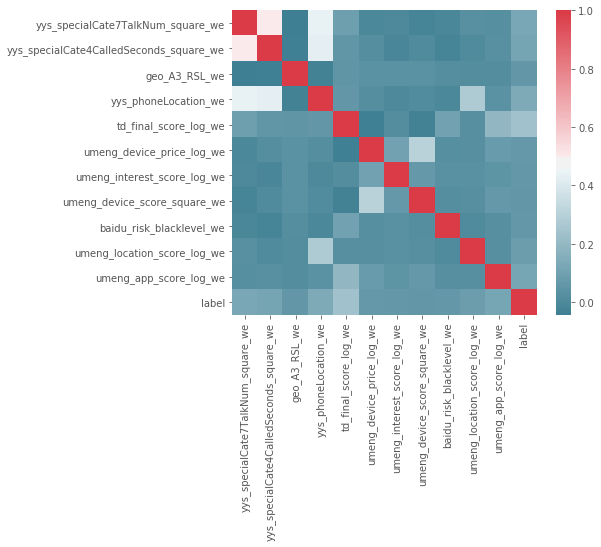

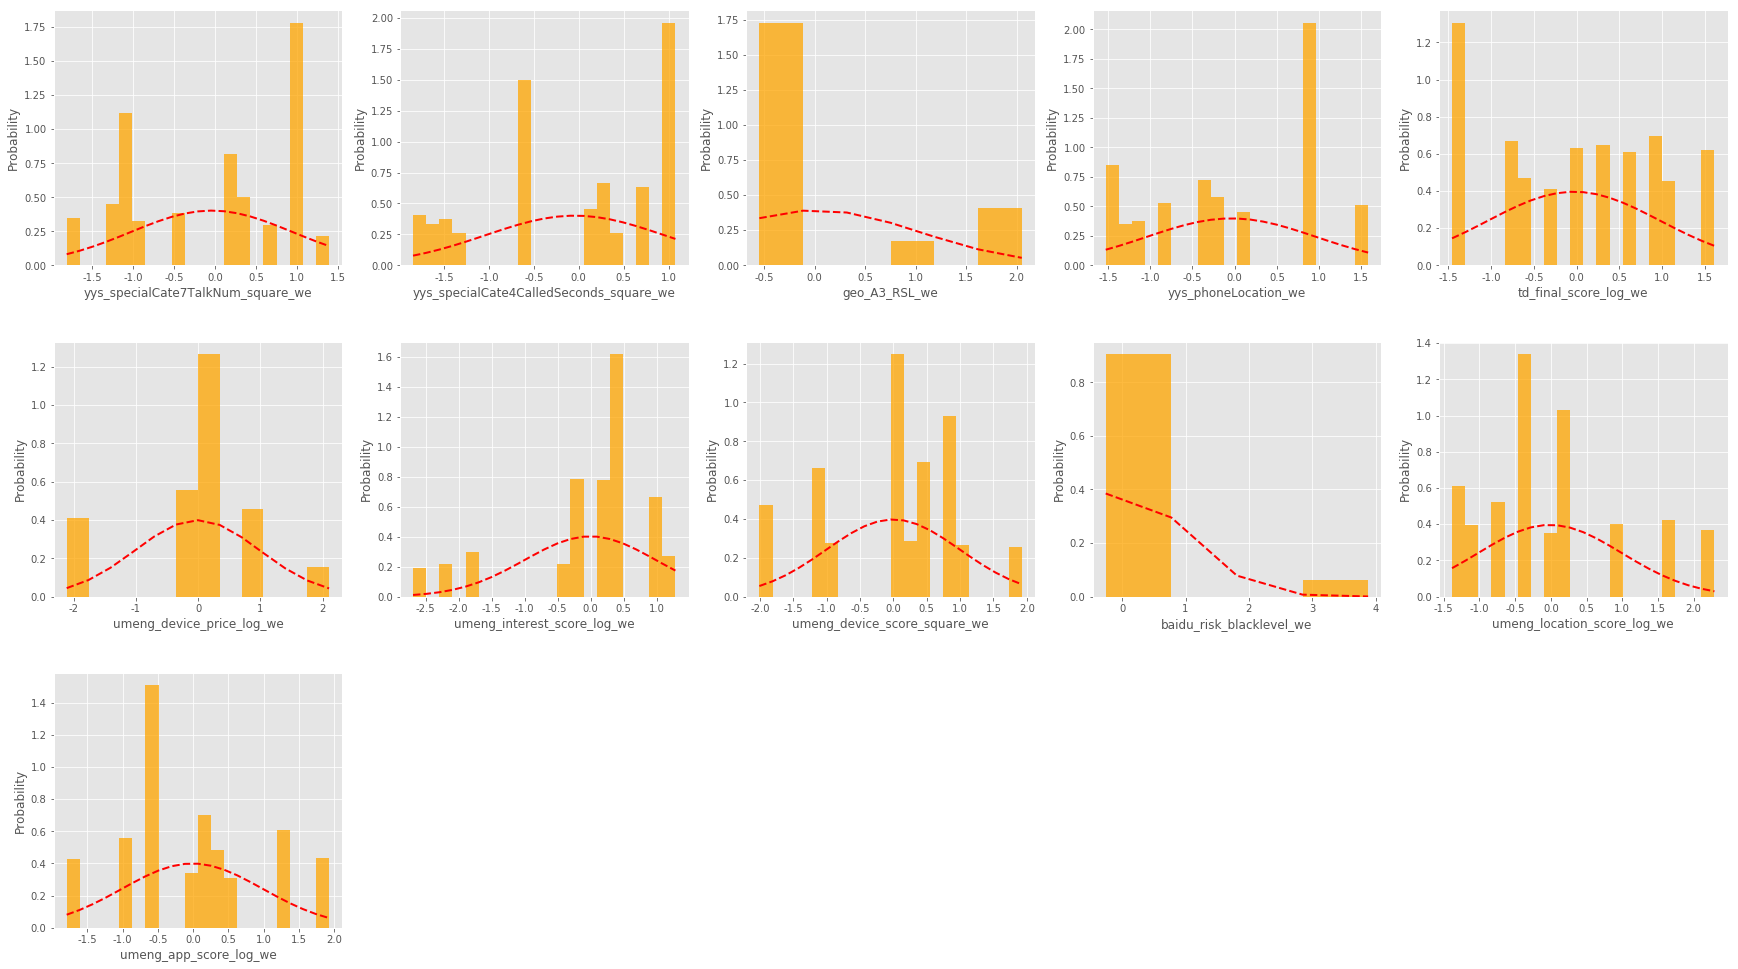

In [33]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################11. FEATURE EVALUATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

print_stype_line();
print('FEATURE EXPLORATION MODULE IS PROCESSING');
print_stype_line()

# Calculate vifs and correlations of columns in the dataframe
df = pd.concat([df_tr, df_va, df_te], axis=0)
vif, _ = get_vif_cor(df, target, plot=True)

print('\n' + '_ ' * 60 + ' ');
print("Vif of features")
print(vif)
#--------------------------------------------------------------------------------------------------#
print('\n' + '_ ' * 60 + ' ');
print("plot histograms of features")

# : params bins: number of bins
plot_hist_all(df, target, bins=10)


## MODEL TRAINING

In [34]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################   12. MODEL TRAINING   ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################
# columns used to train models
col = [i for i in df_tr.columns if i not in [label] + exclude_list + target]

x = pd.concat([df_tr[col], df_va[col], df_te[col]], axis=0)
y = pd.concat([df_tr[label], df_va[label], df_te[label]], axis=0)


In [35]:

print_stype_line();print('MODEL SELECTION MODULE IS PROCESSING');print_stype_line()
best_model, best_model_params, score_dict, params_dict = model_selection(x, y, init_points=5, n_iter=10, acq='ei', cv=5,
                                                                         random_state=2019)


########################################################################################################################
########################################################################################################################

MODEL SELECTION MODULE IS PROCESSING

########################################################################################################################
########################################################################################################################

Apply bayesian optimization to XGBoost model

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   |  lambdA   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.6584   |  67.22    |  0.8391   |  0.1905   |  0.09722  |  36.9     |  6.057    |  11.71    |  0.1181   |
|  2        |  0.7086   |  20.32    |  0.2677   |  0.4294   |  

|  11       |  0.6926   |  0.006374 |  622.1    |
|  12       |  0.6806   |  0.002131 |  776.4    |
|  13       |  0.7063   |  1.0      |  955.9    |
|  14       |  0.6752   |  0.00704  |  170.9    |
|  15       |  0.6301   |  0.001    |  75.39    |
Best combination of parameters are shownn as below
 {'base_estimator': None, 'algorithm': 'SAMME.R', 'n_estimators': 290, 'learning_rate': 0.12287144913767875}

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

Apply bayesian optimization to GBDT model

|   iter    |  target   | learni... | max_depth | min_im... | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.6917   |  0.1851   |  34.96    |  0.000487 |  0.1338   |  28.69    |  24.64    |  0.4137   |
|  2        |  0.6956   |  0.05394  |  21.63    |  0.000313 |  0.2694   |  36.58    |  725.7  

|  8        |  0.693    |  35.67    |  0.4846   |  0.06032  |  39.92    |  349.0    |
|  9        |  0.6799   |  1.121    |  0.4591   |  0.1204   |  37.29    |  327.5    |
|  10       |  0.7043   |  40.0     |  0.999    |  0.01     |  40.0     |  1e+03    |
|  11       |  0.7042   |  40.0     |  0.999    |  0.01     |  2.0      |  1e+03    |
|  12       |  0.6856   |  39.7     |  0.7496   |  0.09174  |  38.34    |  527.4    |
|  13       |  0.6924   |  39.9     |  0.2529   |  0.06092  |  2.331    |  484.4    |
|  14       |  0.6884   |  39.72    |  0.5562   |  0.08299  |  39.13    |  450.0    |
|  15       |  0.6704   |  39.89    |  0.185    |  0.1402   |  36.13    |  10.19    |
Best combination of parameters are shownn as below
 {'n_jobs': -1, 'verbose': 0, 'n_estimators': 1000, 'max_depth': 40, 'min_samples_split': 40, 'min_samples_leaf': 0.01, 'max_features': 0.999}

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

In [36]:
# if best model is lr model, run this
LR_PARAMS = {'print':True, 'equation_file':lr_model_equation_file, 'model_summary_file':lr_model_summary_file, 'vif':vif}

In [59]:
# train lr model
if model_linear:
    model, pred_train_value, pred_val_value, pred_test_value = model_toolkit('lr', df_tr[col], df_tr[label],
                                                                             x_val=df_va[col], y_val=df_va[label],
                                                                             x_test=df_te[col], xgb_params=None,
                                                                             make_prediction=True, **LR_PARAMS)


                                     Results: Logit
Model:                      Logit                   Pseudo R-squared:        0.103      
Dependent Variable:         label                   AIC:                     6539.0413  
Date:                       2019-02-21 17:11        BIC:                     6620.9445  
No. Observations:           6804                    Log-Likelihood:          -3257.5    
Df Model:                   11                      LL-Null:                 -3630.2    
Df Residuals:               6792                    LLR p-value:             9.6995e-153
Converged:                  1.0000                  Scale:                   1.0000     
No. Iterations:             6.0000                                                      
----------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------

In [39]:
# train the best model
model, pred_train_value, pred_val_value, pred_test_value = model_toolkit('xgb', df_tr[col], df_tr[label],
                                                                         x_val=df_va[col], y_val=df_va[label],
                                                                         x_test=df_te[col], xgb_params=XGB_PARAMS,
                                                                         make_prediction=True)


[16:27:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[0]	train-auc:0.657948	eval-auc:0.596963
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[16:27:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[1]	train-auc:0.671511	eval-auc:0.608562
[16:27:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[2]	train-auc:0.680488	eval-auc:0.613162
[16:27:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[3]	train-auc:0.680745	eval-auc:0.609455
[16:27:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning en

[42]	train-auc:0.702707	eval-auc:0.641988
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[43]	train-auc:0.702295	eval-auc:0.641434
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[44]	train-auc:0.702246	eval-auc:0.642053
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[45]	train-auc:0.701947	eval-auc:0.642266
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[46]	train-auc:0.702261	eval-auc:0.642046
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[47]	train-auc:0.702438	eval-auc:0.64319

[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[86]	train-auc:0.707474	eval-auc:0.646966
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[87]	train-auc:0.707785	eval-auc:0.647264
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[88]	train-auc:0.707893	eval-auc:0.647623
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[89]	train-auc:0.708066	eval-auc:0.647411
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[90]	train-auc:0.708221	eval-auc:0.646988
[16:27:38] C:\Users\Administrator\Deskto

[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[129]	train-auc:0.708976	eval-auc:0.647694
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[130]	train-auc:0.70884	eval-auc:0.647659
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[131]	train-auc:0.708759	eval-auc:0.647361
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[132]	train-auc:0.708813	eval-auc:0.647228
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[133]	train-auc:0.708794	eval-auc:0.647287
[16:27:38] C:\Users\Administrator\De

[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[172]	train-auc:0.710938	eval-auc:0.649784
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[173]	train-auc:0.711003	eval-auc:0.649981
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[174]	train-auc:0.711059	eval-auc:0.649762
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[175]	train-auc:0.711186	eval-auc:0.649776
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[176]	train-auc:0.711367	eval-auc:0.649992
[16:27:38] C:\Users\Administrator\D

[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[215]	train-auc:0.713409	eval-auc:0.651519
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[216]	train-auc:0.71347	eval-auc:0.651628
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[217]	train-auc:0.713503	eval-auc:0.651569
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[218]	train-auc:0.713544	eval-auc:0.65169
[16:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[219]	train-auc:0.713548	eval-auc:0.651599
[16:27:38] C:\Users\Administrator\Des

[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[258]	train-auc:0.715266	eval-auc:0.653139
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[259]	train-auc:0.715346	eval-auc:0.653032
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[260]	train-auc:0.715406	eval-auc:0.653383
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[261]	train-auc:0.715458	eval-auc:0.653381
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[262]	train-auc:0.715503	eval-auc:0.653481
[16:27:39] C:\Users\Administrator\D

[300]	train-auc:0.716906	eval-auc:0.653552
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[301]	train-auc:0.716995	eval-auc:0.653835
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[302]	train-auc:0.716947	eval-auc:0.6538
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[303]	train-auc:0.716965	eval-auc:0.653788
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[304]	train-auc:0.716964	eval-auc:0.653834
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[305]	train-auc:0.717017	eval-auc:0.6

[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[344]	train-auc:0.718562	eval-auc:0.654692
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[345]	train-auc:0.718604	eval-auc:0.654801
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[346]	train-auc:0.718703	eval-auc:0.654817
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[347]	train-auc:0.718642	eval-auc:0.654803
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[348]	train-auc:0.718674	eval-auc:0.654829
[16:27:39] C:\Users\Administrator\D

[386]	train-auc:0.719765	eval-auc:0.655226
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[387]	train-auc:0.719795	eval-auc:0.655186
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[388]	train-auc:0.71982	eval-auc:0.655253
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[389]	train-auc:0.71988	eval-auc:0.655301
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[390]	train-auc:0.719922	eval-auc:0.655375
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[391]	train-auc:0.719949	eval-auc:0.6

[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[430]	train-auc:0.721159	eval-auc:0.655887
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[431]	train-auc:0.721143	eval-auc:0.655853
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[432]	train-auc:0.721161	eval-auc:0.655797
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[433]	train-auc:0.721177	eval-auc:0.655851
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[434]	train-auc:0.721233	eval-auc:0.655883
[16:27:39] C:\Users\Administrator\D

[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[473]	train-auc:0.722325	eval-auc:0.656246
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[474]	train-auc:0.722362	eval-auc:0.656218
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[475]	train-auc:0.722363	eval-auc:0.656097
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[476]	train-auc:0.722433	eval-auc:0.656123
[16:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[477]	train-auc:0.722435	eval-auc:0.656107
[16:27:39] C:\Users\Administrator\D

[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[516]	train-auc:0.723132	eval-auc:0.656455
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[517]	train-auc:0.723157	eval-auc:0.656365
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[518]	train-auc:0.723203	eval-auc:0.656445
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[519]	train-auc:0.723238	eval-auc:0.656511
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[520]	train-auc:0.723276	eval-auc:0.656525
[16:27:40] C:\Users\Administrator\D

[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[559]	train-auc:0.724133	eval-auc:0.657044
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[560]	train-auc:0.724145	eval-auc:0.657042
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[561]	train-auc:0.724167	eval-auc:0.657086
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[562]	train-auc:0.724179	eval-auc:0.65709
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[563]	train-auc:0.724201	eval-auc:0.657159
[16:27:40] C:\Users\Administrator\De

[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[602]	train-auc:0.725099	eval-auc:0.657803
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[603]	train-auc:0.725146	eval-auc:0.657789
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[604]	train-auc:0.725159	eval-auc:0.657813
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[605]	train-auc:0.725181	eval-auc:0.65785
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[606]	train-auc:0.72522	eval-auc:0.657836
[16:27:40] C:\Users\Administrator\Des

[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[645]	train-auc:0.72596	eval-auc:0.658218
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[646]	train-auc:0.725989	eval-auc:0.658229
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[647]	train-auc:0.726027	eval-auc:0.65822
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[648]	train-auc:0.726049	eval-auc:0.658218
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[649]	train-auc:0.726078	eval-auc:0.658226
[16:27:40] C:\Users\Administrator\Des

[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 2 pruned nodes, max_depth=2
[688]	train-auc:0.726809	eval-auc:0.658442
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[689]	train-auc:0.726808	eval-auc:0.658458
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[690]	train-auc:0.726826	eval-auc:0.658388
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[691]	train-auc:0.726862	eval-auc:0.658353
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[692]	train-auc:0.726886	eval-auc:0.658402
[16:27:40] C:\Users\Administrator\D

[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[731]	train-auc:0.72735	eval-auc:0.658358
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[732]	train-auc:0.72737	eval-auc:0.658331
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[733]	train-auc:0.727381	eval-auc:0.65848
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[734]	train-auc:0.727392	eval-auc:0.658432
[16:27:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[735]	train-auc:0.727438	eval-auc:0.658382
[16:27:40] C:\Users\Administrator\Desk

Stopping. Best iteration:
[723]	train-auc:0.727239	eval-auc:0.658557

Average of predictive values for train set: 54.3%
Average of predictive values for validation set: 55.1%
Average of predictive values for test set: 45.3%


In [40]:
with HiddenPrints():
    _, summary = cv_check(x[col], y, clf_name='xgb', xgb_params=XGB_PARAMS, x_test=None, y_test=None,
                          cv=5, random_state=2019, silent=True)
summary

auc                 ks           threshold           pass_rate  \
          mean       std     mean       std      mean       std      mean   
index                                                                       
train  0.70898  0.007508  0.32482  0.014347   0.54126  0.019044   0.55698   
val    0.69258  0.030463  0.31238  0.040727   0.53140  0.010633   0.52114   

                missing_negative_rate            
            std                  mean       std  
index                                            
train  0.035358               0.11212  0.003017  
val    0.058278               0.10936  0.015531

## MODEL EVALUATION

          auc      ks  threshold pass_rate missing_negative_rate
train  0.7215  0.3364     0.2294     59.0%                 12.6%
val    0.6660  0.2661     0.2316     58.8%                 14.3%
test   0.7257  0.3968     0.1812     67.3%                  3.0%
cutpoints derived from train set are  0.01582332384468829, 0.07037257421242081, 0.09795981966506222, 0.12917658542361202, 0.1577948537971157, 0.1950986089937861, 0.23495944220219547, 0.2879429920954476, 0.3458903495336176, 0.4316814511945598, 0.7863746226111655


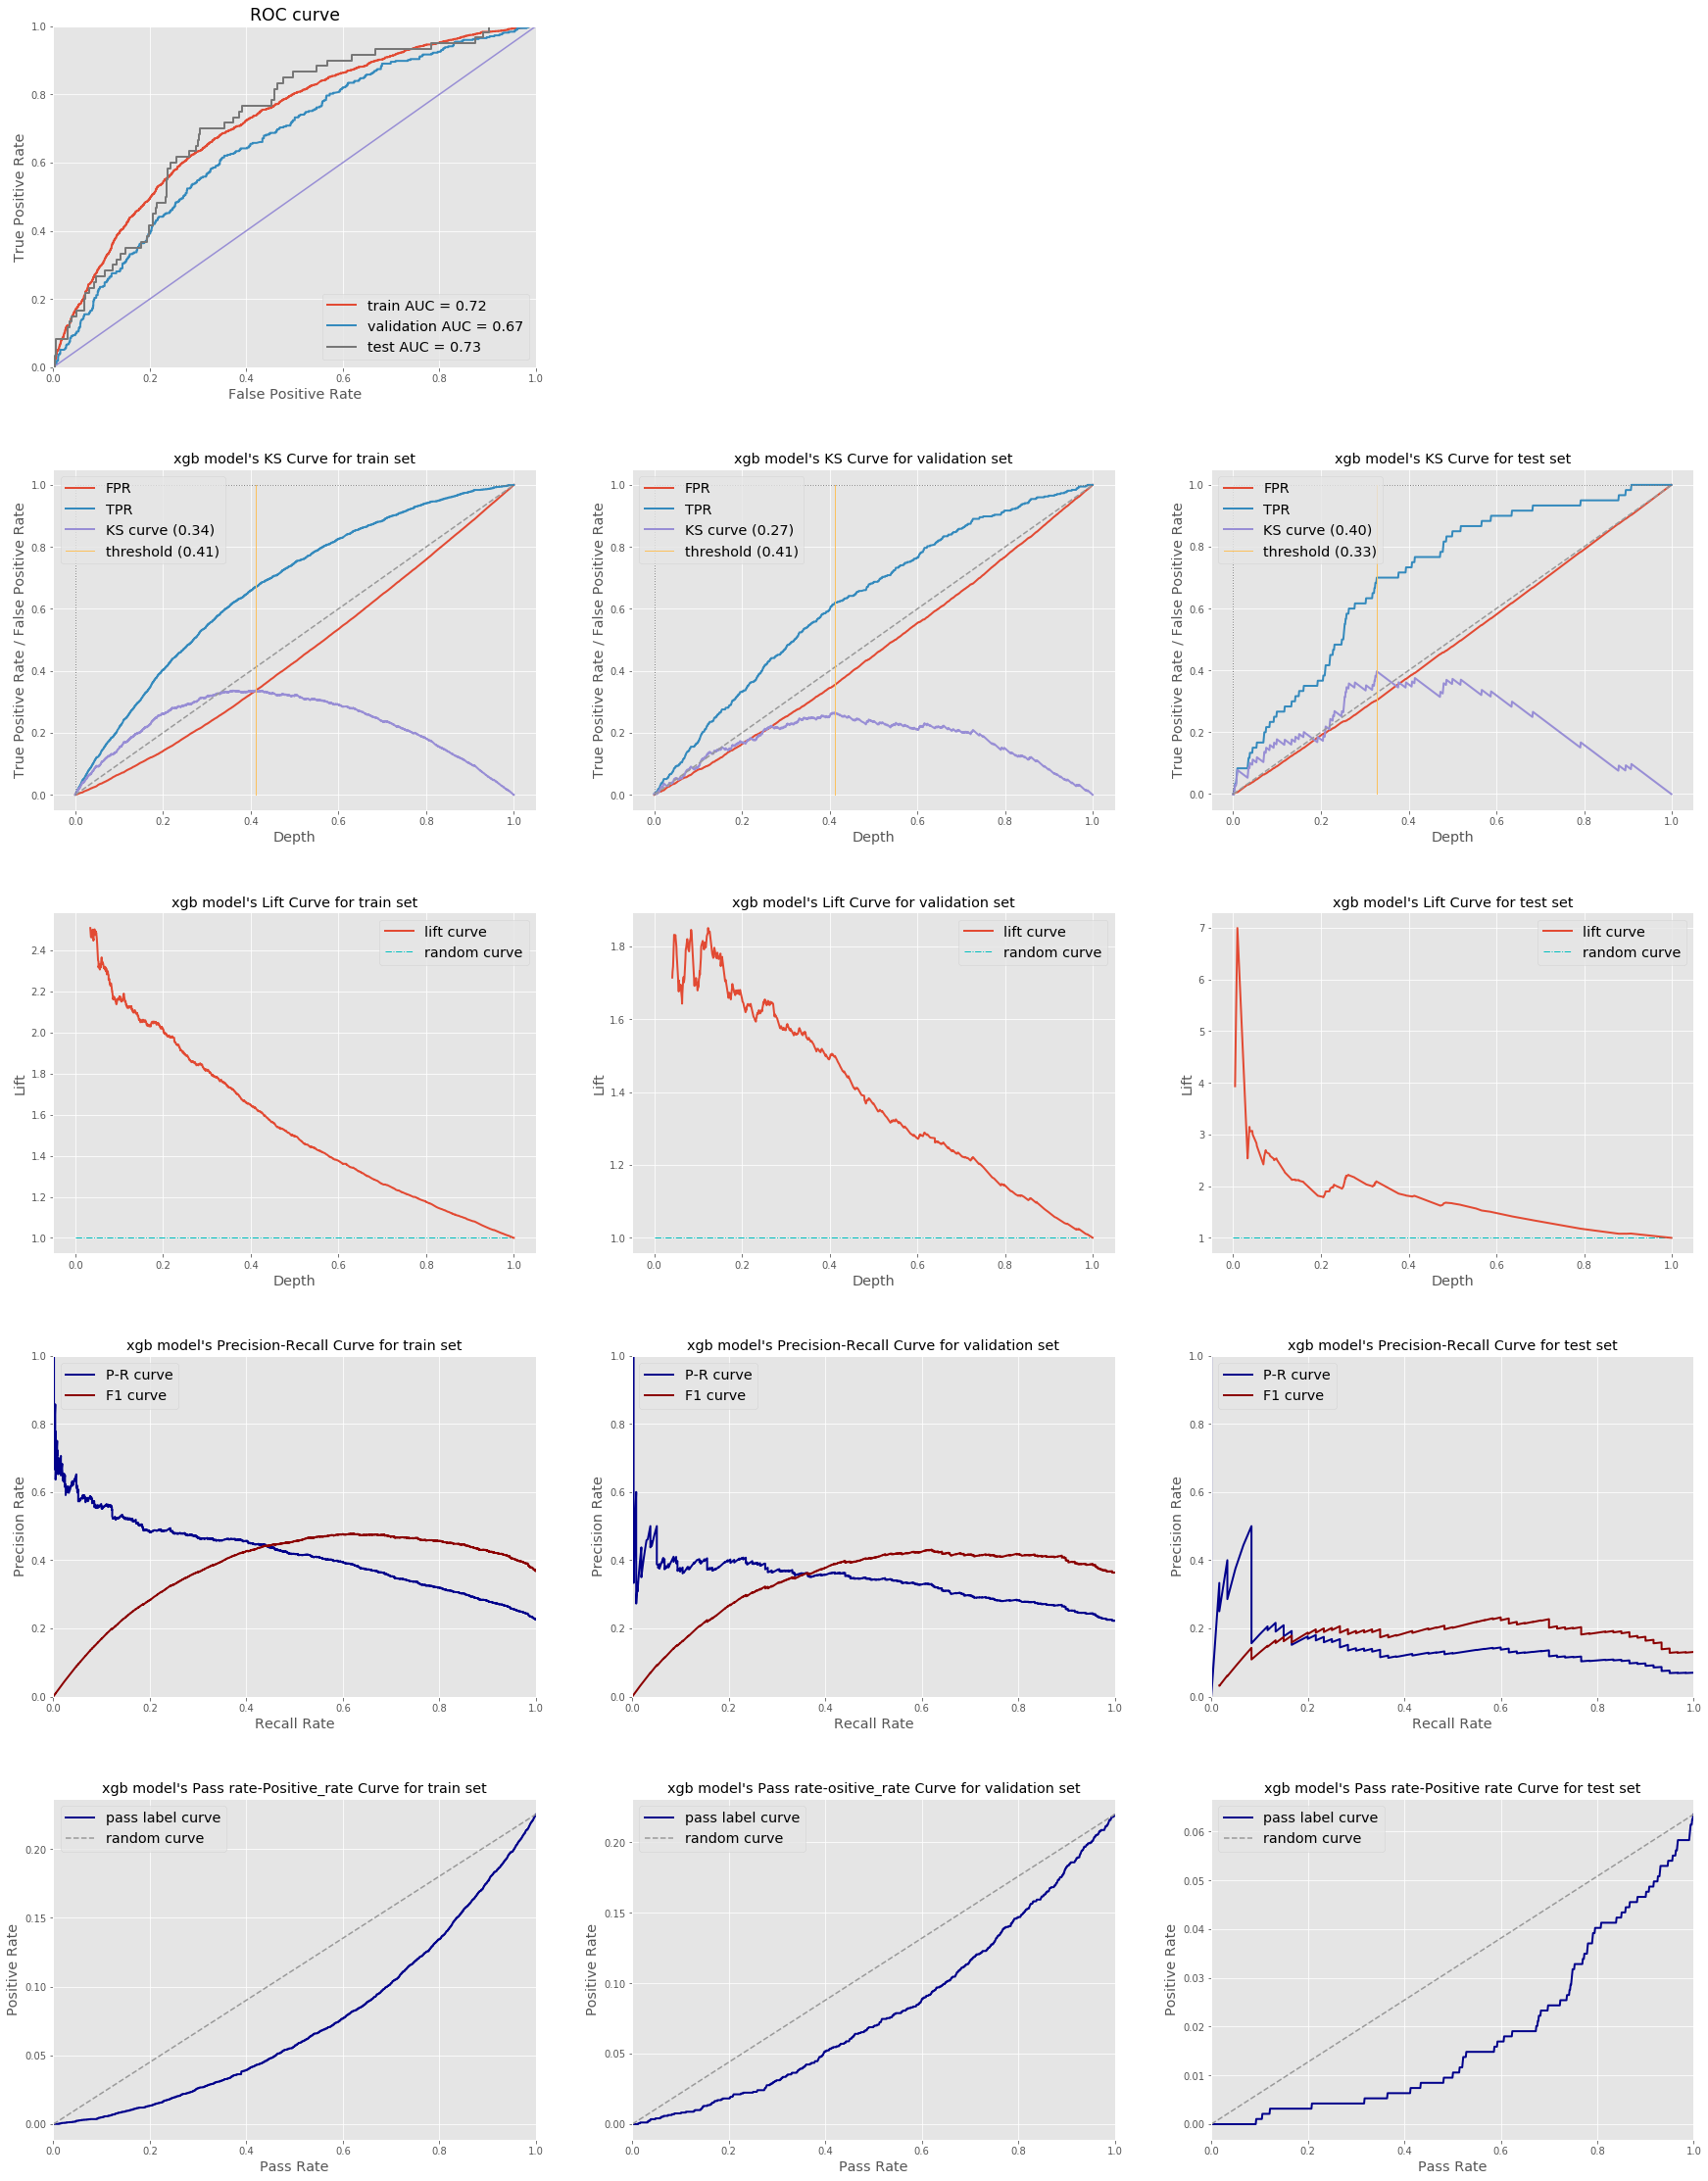

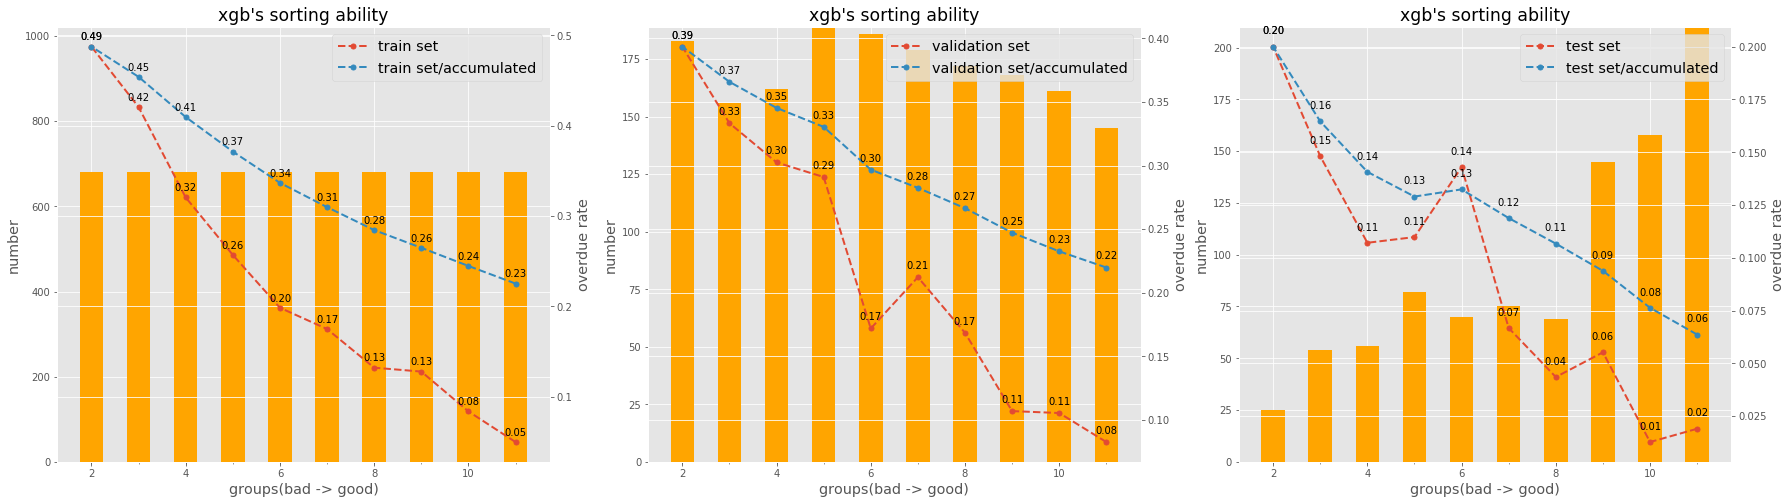

In [60]:
####################################################################################################
####################################################################################################
######################################                        ######################################
######################################  13. MODEL EVALUATION  ######################################
######################################                        ######################################
####################################################################################################
####################################################################################################

tr, va, te = plot_all_figures(pred_train_value, df_tr[label], pred_val_value, df_va[label],
                              pred_test_value=pred_test_value,
                              real_test_label=df_te[label], pos_label=1)
